In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [2]:
#import dataset
num_classes=10
input_shape=(32,32,3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [51]:
x_train=x_train[:500]
y_train=y_train[:500]
x_test=x_test[:100]
y_test=y_test[:100]

In [52]:
x_train.shape

(500, 32, 32, 3)

In [53]:
y_train.shape

TensorShape([500, 1, 1])

In [54]:
x_test.shape


(100, 32, 32, 3)

In [55]:
y_test.shape

(100, 1)

In [56]:
y_train=tf.expand_dims(y_train,axis=1)

In [57]:
###Hyper Parameter Definition

In [58]:
learning_rate=0.001
weight_decay=0.0001
batch_size=256
num_epochs=30
image_size=72
patch_size=6
num_patches=(image_size//patch_size)**2
projection_dim=64
num_heads=4
transformer_units=[projection_dim*2,projection_dim]
transformer_layers=8
mlp_head_units=[2048,1024]

In [59]:
## Build ViT Classifier Model

In [60]:
#3.1Data Augmentation

In [61]:
data_augmentation=keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size,image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.2),
        layers.RandomZoom(height_factor=0.2,width_factor=0.2),
        
    ],
    name="data_augmentation",)
data_augmentation.layers[0].adapt(x_train)

In [62]:
#3.2Define MLP Architecture

In [63]:
def mlp(x,hidden_units,dropout_rate):
    for units in hidden_units:
        x=layers.Dense(units,activation=tf.nn.gelu)(x)
        x=layers.Dropout(dropout_rate)(x)
    return x

In [64]:
#3.3Patches

In [65]:
class Patches(layers.Layer):
    def __init__(self,patch_size):
        super(Patches,self).__init__()
        self.patch_size=patch_size
    def call(self,images):
        batch_size=tf.shape(images)[0]
        patches=tf.image.extract_patches(images=images,sizes=[1,self.patch_size,self.patch_size,1],strides=[1,self.patch_size,self.patch_size,1],rates=[1,1,1,1],padding="VALID")
        patch_dim=patches.shape[-1]
        patches=tf.reshape(patches,[batch_size,-1,patch_dim])
        return patches

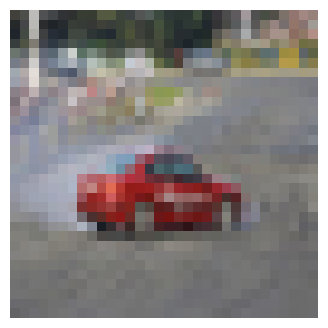

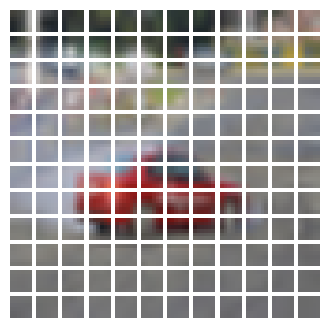

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
image=x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image)
plt.axis('off')

resized_image=tf.image.resize(tf.convert_to_tensor([image]),size=(image_size,image_size))
patches=Patches(patch_size)(resized_image)

n=int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4,4))
for i,patch in enumerate(patches[0]):
    ax=plt.subplot(n,n,i+1)
    patch_img=tf.reshape(patch,(patch_size,patch_size,3))
    plt.imshow(patch_img.numpy().astype('uint8'))
    plt.axis('off')
    

In [67]:
class PatchEncoder(layers.Layer):
    def __init__(self,num_patches,projection_dim):
        super(PatchEncoder,self).__init__()
        self.num_patches=num_patches
        self.projection_dim=projection_dim
        self.projection=layers.Dense(units=projection_dim)
        self.position_embedding=layers.Embedding(input_dim=num_patches,output_dim=projection_dim)
    def call(self,patch):
        positions=tf.range(start=0,limit=self.num_patches,delta=1)
        encoded=self.projection(patch)+self.position_embedding(positions)
        return encoded

In [72]:
def create_vit_classifier():
    inputs=layers.Input(shape=input_shape)
    augmentation=data_augmentation(inputs)
    patches=Patches(patch_size)(augmentation)
    encoded_patches=PatchEncoder(num_patches,projection_dim)(patches)
    
    for _ in range(transformer_layers):
        x1=layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output=layers.MultiHeadAttention(num_heads=num_heads,key_dim=projection_dim,dropout=0.1)(x1,x1)
        x2=layers.Add()([attention_output,encoded_patches])
        x3=layers.LayerNormalization(epsilon=1e-6)(x2)
        x4=mlp(x3,hidden_units=transformer_units,dropout_rate=0.1)
        encoded_patches=layers.Add()([x4,x2])
        
    representation=layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation=layers.Flatten()(representation)
    representation=layers.Dropout(0.5)(representation)
    
    features=mlp(representation,hidden_units=mlp_head_units,dropout_rate=0.5)
    logits=layers.Dense(num_classes)(features)
    
    model=keras.Model(inputs=inputs,outputs=logits)
    return model

In [73]:
def run(model):
    optimizer=tfa.optimizers.AdamW(learning_rate=learning_rate,weight_decay=weight_decay)
    
    model.compile(optimizer=optimizer , loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                  metrics = [keras.metrics.SparseCategoricalAccuracy(name="accuracy"), 
                             keras.metrics.SparseTopKCategoricalAccuracy(5,name="top_5_accuracy"),],)
    checkpoint_filepath="./tmp/checkpoint"
    checkpoint_callback=keras.callbacks.ModelCheckpoint(checkpoint_filepath,monitor="val_accuracy",save_best_only=True,save_weights_only=True)
    
    history=model.fit(x=x_train, y=y_train, batch_size=batch_size,epochs=num_epochs,validation_split=0.1,callbacks=[checkpoint_callback],)
    
    _, accuracy, top_5_accuracy=model.evaluate(x_test,y_test)
    print(f"Test Accuracy:{round(accuracy*100),2}%")
    print(f"Test top 5 Accuracy:{round(top_5_accuracy*100),2}%")

In [74]:
vit_classifier.output_shape

(None, 10)

In [75]:
vit_classifier=create_vit_classifier()
history=run(vit_classifier)

Epoch 1/30
2/2 [==============================] - 23s 9s/step - loss: 6.1926 - accuracy: 0.0940 - top_5_accuracy: 0.5111 - val_loss: 4.5851 - val_accuracy: 0.1144 - val_top_5_accuracy: 0.6200
Epoch 2/30
2/2 [==============================] - 16s 7s/step - loss: 6.2721 - accuracy: 0.1045 - top_5_accuracy: 0.5778 - val_loss: 3.7551 - val_accuracy: 0.1052 - val_top_5_accuracy: 0.7200
Epoch 3/30
2/2 [==============================] - 16s 7s/step - loss: 4.3887 - accuracy: 0.0960 - top_5_accuracy: 0.6578 - val_loss: 3.0619 - val_accuracy: 0.0760 - val_top_5_accuracy: 0.7200
Epoch 4/30
2/2 [==============================] - 16s 7s/step - loss: 3.4043 - accuracy: 0.1042 - top_5_accuracy: 0.6689 - val_loss: 2.3440 - val_accuracy: 0.0932 - val_top_5_accuracy: 0.7400
Epoch 5/30
2/2 [==============================] - 15s 7s/step - loss: 2.7036 - accuracy: 0.0996 - top_5_accuracy: 0.7022 - val_loss: 2.0677 - val_accuracy: 0.0984 - val_top_5_accuracy: 0.6800
Epoch 6/30
2/2 [========================

In [76]:
class_names=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [77]:
def imp_predict(images,model):
    if len(images.shape)==3:
        out=model.predict(images.reshape(-1,*images.shape))
    else:
        out=model.predict(images)
    prediction=np.argmax(out,axis=1)
    img_prediction=[class_names[i] for i in prediction]
    return img_prediction

['horse']


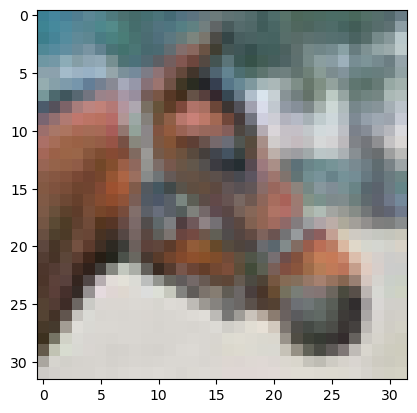

In [80]:
index=17
plt.imshow(x_test[index])
prediction=imp_predict(x_test[index],vit_classifier)
print(prediction)